# Predicción de la Demanda: ARIMA

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams

import datetime as dt
import matplotlib.dates as mdates

from pyspark import SparkContext, SQLContext
from pyspark.ml.feature import VectorAssembler

from pyspark.sql import SQLContext
from pyspark.sql.types import *

import warnings
warnings.filterwarnings('ignore')

sqlCtx = SQLContext(sc)

##### Carga de R para el modelo en ARIMA

In [2]:
%load_ext rpy2.ipython

## 1. Carga y Procesado de Datos

### 1.1. Carga de datos por tramo horario 

In [3]:
#Carga de los datos para los dias Laborables
df = sqlContext.sql("select fecha,mes,dia,anho,dia_semana,festivo,sum(n_viajeros) as nviajeros,max(intensidad_evento) as intensidad_evento,max(lluvia_tramo) as lluvia,max(ocupacion_trafico) as ocupacion_trafico,max(inten_lluvia_tramo) as inten_lluvia from emt_smartbus.viajeros_tramos_master_nooutliers \
where linea=1 and fecha<>20160229 and tramo>12 and tramo<=18 GROUP BY fecha,mes,anho,dia,dia_semana,festivo ORDER BY fecha")

In [4]:
df.show()

+--------+---+---+----+----------+-------+---------+-----------------+------+------------------+------------------+
|   fecha|mes|dia|anho|dia_semana|festivo|nviajeros|intensidad_evento|lluvia| ocupacion_trafico|      inten_lluvia|
+--------+---+---+----+----------+-------+---------+-----------------+------+------------------+------------------+
|20150101|  1|  1|2015|         J|      1|     1125|             null|     0|              null|               0.0|
|20150102|  1|  2|2015|         V|      0|     3592|             null|     0|              null|               0.0|
|20150103|  1|  3|2015|         S|      0|     3001|             null|     0|              null|               0.0|
|20150104|  1|  4|2015|         D|      0|     2260|             null|     0|              null|               0.0|
|20150105|  1|  5|2015|         L|      0|     2767|             null|     0|              null|               0.0|
|20150106|  1|  6|2015|         M|      1|     1342|             null|  

In [5]:
df = df.toPandas()

### 1.2. Procesado de los datos

##### Creación de Variables Derivadas

In [6]:
df['fecha_date'] = df['fecha'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))

In [7]:
# Funcion para separar los dias en las semanas del mes
def weeks(row):
    # Inicio del mes
    if row['dia'] <= 7:
        val = 0
    # Mediados del mes
    elif (row['dia']>7) & (row['dia']<=21):
        val = 1
    # Fin de mes
    else:
        val = 2

    return val

In [8]:
df['semana_mes'] = df.apply (lambda row: weeks (row),axis=1)

In [9]:
df['day_of_week'] = df['fecha_date'].dt.dayofweek

In [10]:
df.head()

,fecha,mes,dia,anho,dia_semana,festivo,nviajeros,intensidad_evento,lluvia,ocupacion_trafico,inten_lluvia,fecha_date,semana_mes,day_of_week
0,20150101,1,1,2015,J,1,1125,None,0,NaN,0.0,2015-01-01,0,3
1,20150102,1,2,2015,V,0,3592,None,0,NaN,0.0,2015-01-02,0,4
2,20150103,1,3,2015,S,0,3001,None,0,NaN,0.0,2015-01-03,0,5
3,20150104,1,4,2015,D,0,2260,None,0,NaN,0.0,2015-01-04,0,6
4,20150105,1,5,2015,L,0,2767,None,0,NaN,0.0,2015-01-05,0,0


In [11]:
df_filter= df[['mes','festivo','nviajeros','intensidad_evento','lluvia','inten_lluvia','ocupacion_trafico','semana_mes','day_of_week','fecha_date']]

##### Reemplazamos los Outliers por 0

In [12]:
df_filter=df_filter.fillna(0)

In [13]:
df_filter.head()

,mes,festivo,nviajeros,intensidad_evento,lluvia,inten_lluvia,ocupacion_trafico,semana_mes,day_of_week,fecha_date
0,1,1,1125,0,0,0.0,0.0,0,3,2015-01-01
1,1,0,3592,0,0,0.0,0.0,0,4,2015-01-02
2,1,0,3001,0,0,0.0,0.0,0,5,2015-01-03
3,1,0,2260,0,0,0.0,0.0,0,6,2015-01-04
4,1,0,2767,0,0,0.0,0.0,0,0,2015-01-05


### 1.3. Filtro de Variables y Conversión a R

In [14]:
df_filter.columns = ['mes','festivo','nviajeros','intensidad_evento','lluvia','inten_lluvia','ocupacion_trafico','semana_mes','day_of_week','fecha']

In [15]:
df_clean=df_filter.sort_values(['fecha'], ascending=[1])

In [16]:
fecha_min=df_clean['fecha'].min()
fecha_max=df_clean['fecha'].max()

In [17]:
import pandas.rpy.common as com

df_clean_r = com.convert_to_r_dataframe(df_clean)

## 2. Predicción

In [18]:
%R library(lubridate)
%R library(forecast)
%R library(zoo)

array(['zoo', 'forecast', 'lubridate', 'tools', 'stats', 'graphics',
       'grDevices', 'utils', 'datasets', 'methods', 'base'], 
      dtype='|S9')

 Call:
 stl(x = myts, s.window = 365)

 Time.series components:
    seasonal              trend            remainder         
 Min.   :-1955.1165   Min.   :2897.632   Min.   :-1596.7242  
 1st Qu.: -450.7006   1st Qu.:2977.909   1st Qu.: -415.8196  
 Median :   76.8387   Median :3042.443   Median :   22.2935  
 Mean   :   16.6074   Mean   :3038.077   Mean   :    9.6871  
 3rd Qu.:  670.1975   3rd Qu.:3102.428   3rd Qu.:  458.2111  
 Max.   : 2192.9793   Max.   :3142.092   Max.   : 1570.4805  
 IQR:
     STL.seasonal STL.trend STL.remainder data  
     1120.9        124.5     874.0        1774.0
   %  63.2          7.0      49.3         100.0 

 Weights: all == 1

 Other components: List of 5
 $ win  : Named num [1:3] 365 551 365
 $ deg  : Named int [1:3] 0 1 1
 $ jump : Named num [1:3] 37 56 37
 $ inner: int 2
 $ outer: int 0
                   ME     RMSE      MAE      MPE     MAPE      MASE        ACF1
Training set 1.449742 350.9802 254.8858 -1.31399 10.14676 0.2728418 -0.05057345
[1

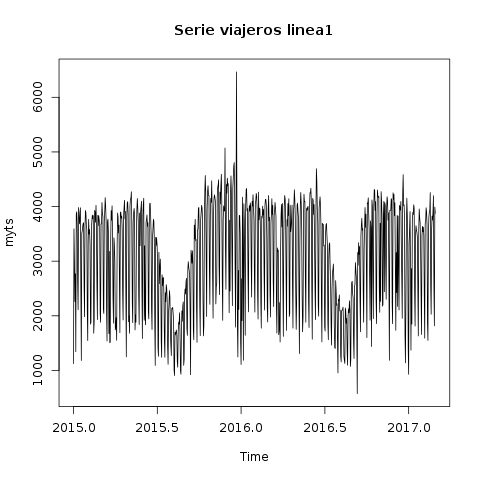

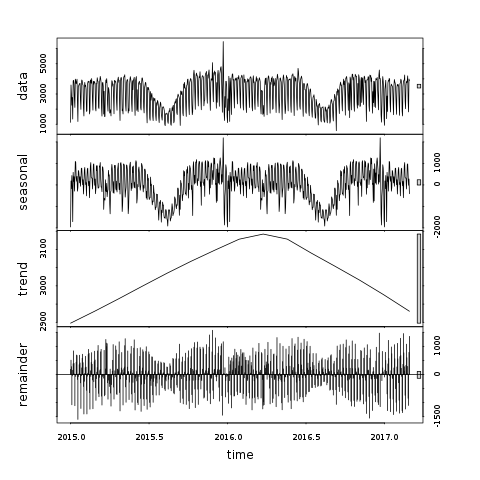

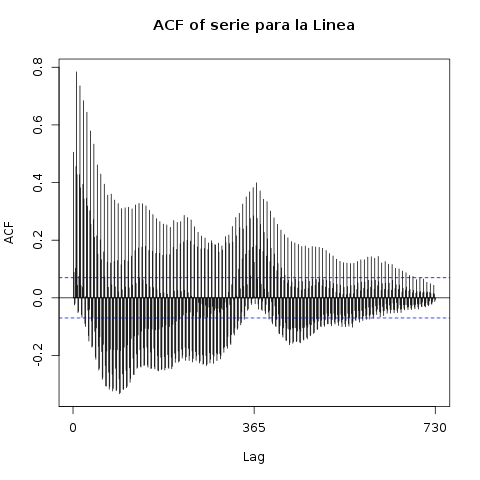

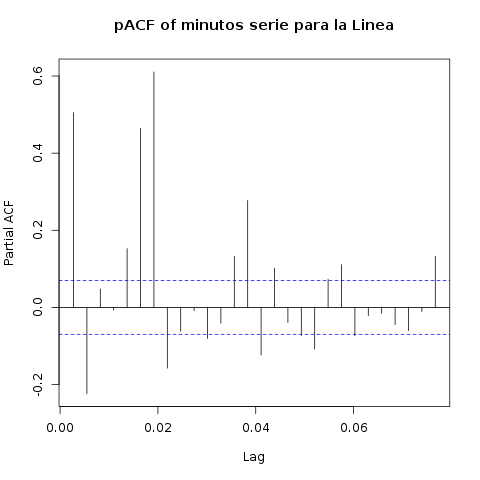

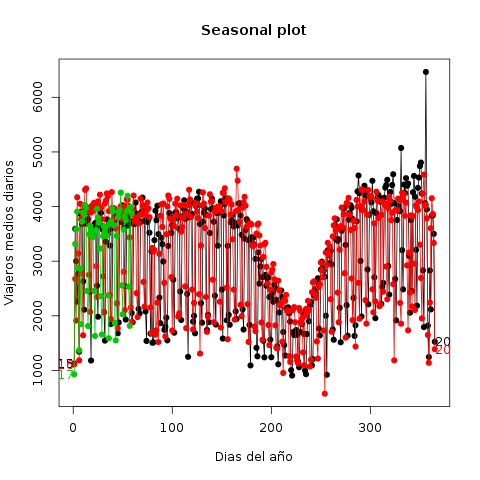

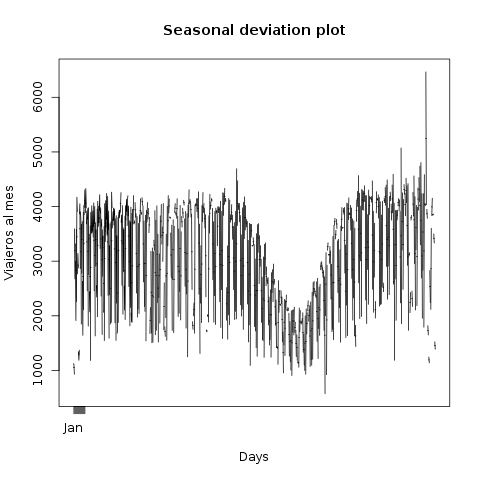

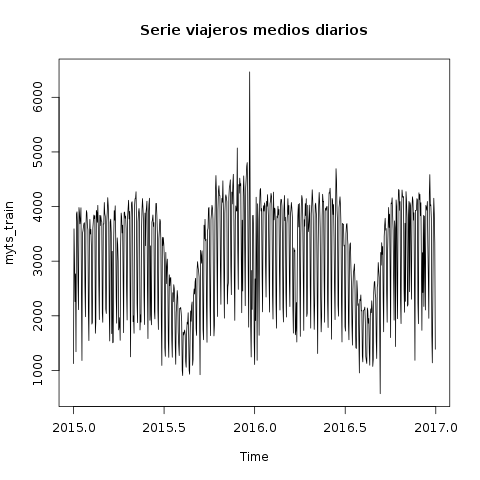

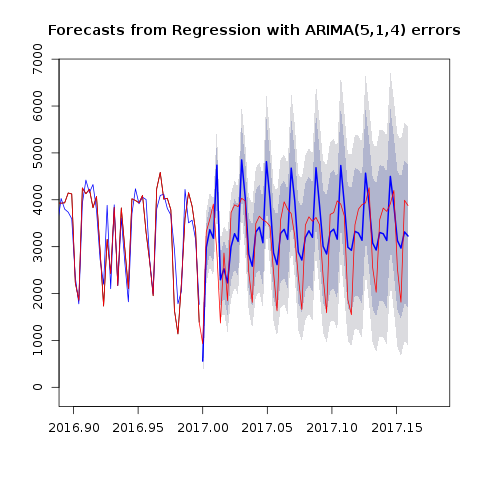

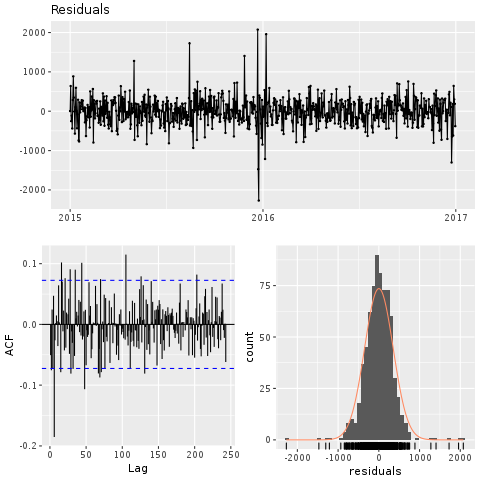

In [23]:
%%R -i df_clean_r

min.fecha <- min(as.Date(df_clean_r$fecha))
max.fecha <- max(as.Date(df_clean_r$fecha))

dummyVector = as.vector(t(df_clean_r$nviajeros))
myts <- ts(dummyVector, start=c(year(min.fecha), month(min.fecha)),  frequency=365)

plot(myts, main="Serie viajeros linea1")

plot(stllc <- stl(myts, 365))
summary(stllc)

Acf(myts, main="ACF of serie para la Linea")
pacf(myts, main="pACF of minutos serie para la Linea")

seasonplot(myts,ylab="Viajeros medios diarios", xlab="Dias del año",
           main="Seasonal plot",
           year.labels=TRUE, year.labels.left=TRUE, col=1:3, pch=19)

monthplot(myts,ylab="Viajeros al mes",xlab="Days",xaxt="n",
          main="Seasonal deviation plot")
axis(1,at=1:12,labels=month.abb,cex=0.3)

# myts_hor_train <- window(myts, start=c(2015, 01), end=c(2016, 12))
myts_train <- window(myts, start=c(2015, 01), end=c(2016, 365))
myts_test <- window(myts, start=c(2017, 01))

lambda <- BoxCox.lambda(myts_train)
lambda

plot(myts_train, main="Serie viajeros medios diarios")


############################################ model auto.arima ###############################################

myts_fest_train <- ts(data=df_clean_r$festivo, start=c(2015, 01), end=c(2016, 365),  frequency=365)
myts_fest_test <- ts(data=df_clean_r$festivo, start=c(2017, 01),end=c(2017,59), frequency = 365)

myts_day_train <- ts(data=df_clean_r$day_of_week, start=c(2015, 01), end=c(2016, 365),  frequency=365)
myts_day_test <- ts(data=df_clean_r$day_of_week, start=c(2017, 01),end=c(2017,59), frequency = 365)

myts_semana_train <- ts(data=df_clean_r$semana_mes, start=c(2015, 01), end=c(2016, 365),  frequency=365)
myts_semana_test <- ts(data=df_clean_r$semana_mes, start=c(2017, 01),end=c(2017,59), frequency = 365)

myts_lluvia_train <- ts(data=df_clean_r$inten_lluvia, start=c(2015, 01), end=c(2016, 365),  frequency=365)
myts_lluvia_test <- ts(data=df_clean_r$inten_lluvia, start=c(2017, 01),end=c(2017,59), frequency = 365)

myts_mes_train <- ts(data=df_clean_r$mes, start=c(2015, 01), end=c(2016, 365),  frequency=365)
myts_mes_test <- ts(data=df_clean_r$mes, start=c(2017, 01),end=c(2017,59), frequency = 365)

myts_traf_train <- ts(data=df_clean_r$ocupacion_trafico, start=c(2015, 01), end=c(2016, 365),  frequency=365)
myts_traf_test <- ts(data=df_clean_r$ocupacion_trafico, start=c(2017, 01),end=c(2017,59), frequency = 365)

xreg_train <- cbind(myts_fest_train,myts_day_train,myts_semana_train,myts_lluvia_train,myts_mes_train,myts_traf_train)
xreg_test <-  cbind(myts_fest_test,myts_day_test,myts_semana_test,myts_lluvia_test,myts_mes_test,myts_traf_test)

fit <- auto.arima(myts_train, seasonal=TRUE ,xreg=xreg_train)
fit                  
print(accuracy(fit))

future <- forecast(fit,h=59 ,xreg=xreg_test)


print(length(future))

predict <- future[[4]] 
aux <- predict-myts_test

aux2 <- myts_test-mean(myts_test)
coef <- 1-sum(aux*aux)/sum(aux2*aux2)

print("SCORING:")
aux3 <- predict-mean(myts_test)
aux4 <- myts_test-mean(myts_test)
ratio <- sum(aux3*aux3)/sum(aux4*aux4)

# CALCULO DEL COEFICIENTE DE CORRELACION
print(ratio)
#print(future)
print(accuracy(future,myts_test))

a<-predict*predict
fitted_plot <- ts(data=fit$fitted, start=c(2017, 01),end=c(2017,59))
myts_plot <- ts(data=myts, start=c(2017, 01),end=c(2017,59))
future_plot <- ts(data=future, start=c(2017, 01),end=c(2017,59))

plot(future,xlim=c(2016.9, 2017.18))
lines(fit$fitted,col="blue") 
lines(myts,col="red")

checkresiduals(fit, lag=365)